In [2]:
from plot import visualisation_plot, prepare_data, to_table, save_plot

In [3]:
%matplotlib widget

In [4]:
list_dict = prepare_data.get_list_dict()

# I. Visualisation plot

In [5]:
vplot = visualisation_plot.VisualisationPlot(list_dict)

## 1) Scatter plot in 3D

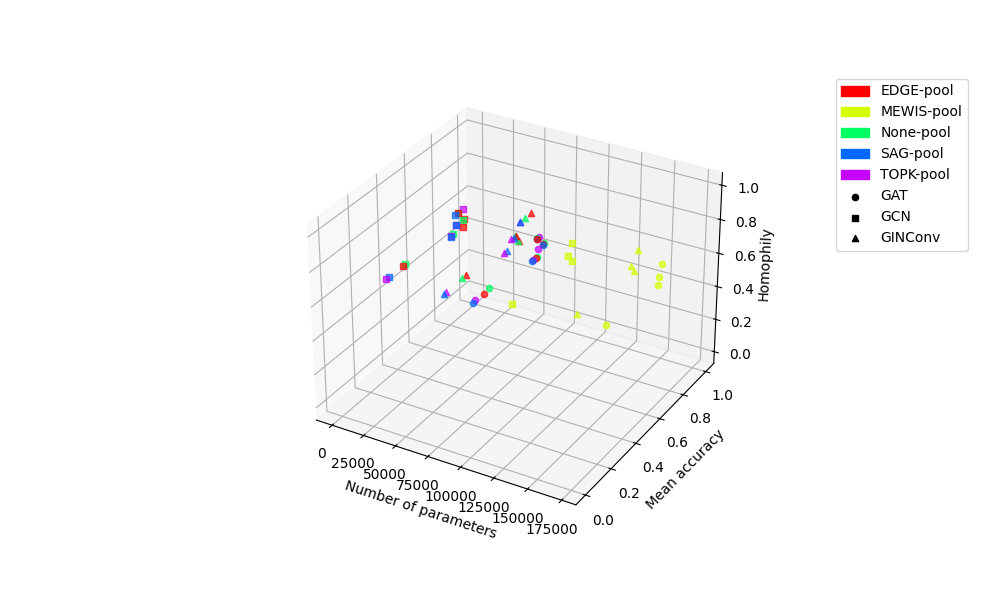

In [12]:
vplot.plot_from_dict(alpha=.7);

## 2) Pairplot

In [10]:
list_dict[0].keys()

dict_keys(['alpha', 'attention_heads', 'batch_size', 'convolution_layer', 'dataset', 'deterministic_algorithms', 'global_pooling_layer', 'local_pooling_layer', 'lr', 'max_epochs', 'patience', 'split 1', 'split 2', 'split 3', 'split 4', 'split 5', 'split 6', 'split 7', 'split 8', 'split 9', 'split 10', 'nb_parameters', 'mean_accuracy', 'std_accuracy', 'Training time', 'homophily', 'pooling_and_archi', 'avg_nodes', 'avg_edges'])

In [ ]:
vplot.pairplot_from_dict(
                   [
                       ('avg_nodes','mean_accuracy'),
                       ('avg_edges','mean_accuracy'),
                    ],
                   dataset=None,
                   dim_grid_subplots=(2,1),
                   figsize=(8,9),
                   plot=False,
                   kwargs1={'alpha' : .7, 's' : 30.},
                   kwargs2={'bbox_to_anchor' : (1.01,1)},
                   kwargs3={'alpha' : .7, 'linestyle' : ':', 'linewidth' : .7},
                   padding_subplots=.07
                   )

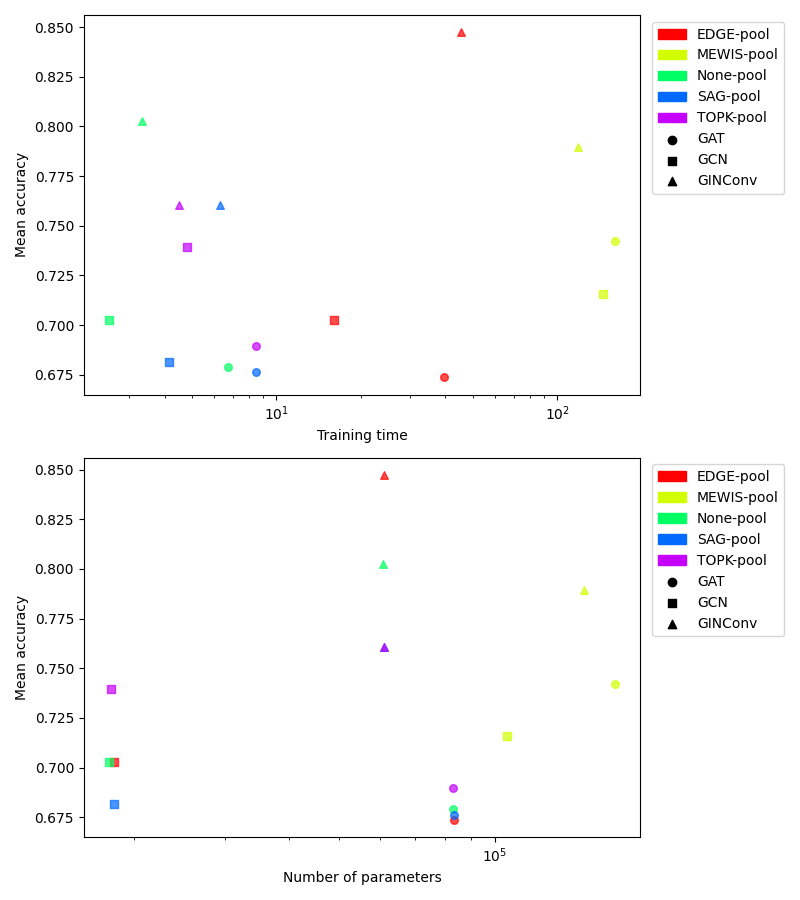

In [13]:
vplot.pairplot_from_dict(
                   [
                       ('Training time','mean_accuracy'),
                       ('nb_parameters','mean_accuracy'),
                    ],
                   dataset="MUTAG",
                   dim_grid_subplots=(2,1),
                   figsize=(8,9),
                   plot=False,
                   kwargs1={'alpha' : .7, 's' : 30.},
                   kwargs2={'bbox_to_anchor' : (1.01,1)},
                   kwargs3={'alpha' : .7, 'linestyle' : ':', 'linewidth' : .7},
                   padding_subplots=.07
                   )

## 3) Barplot

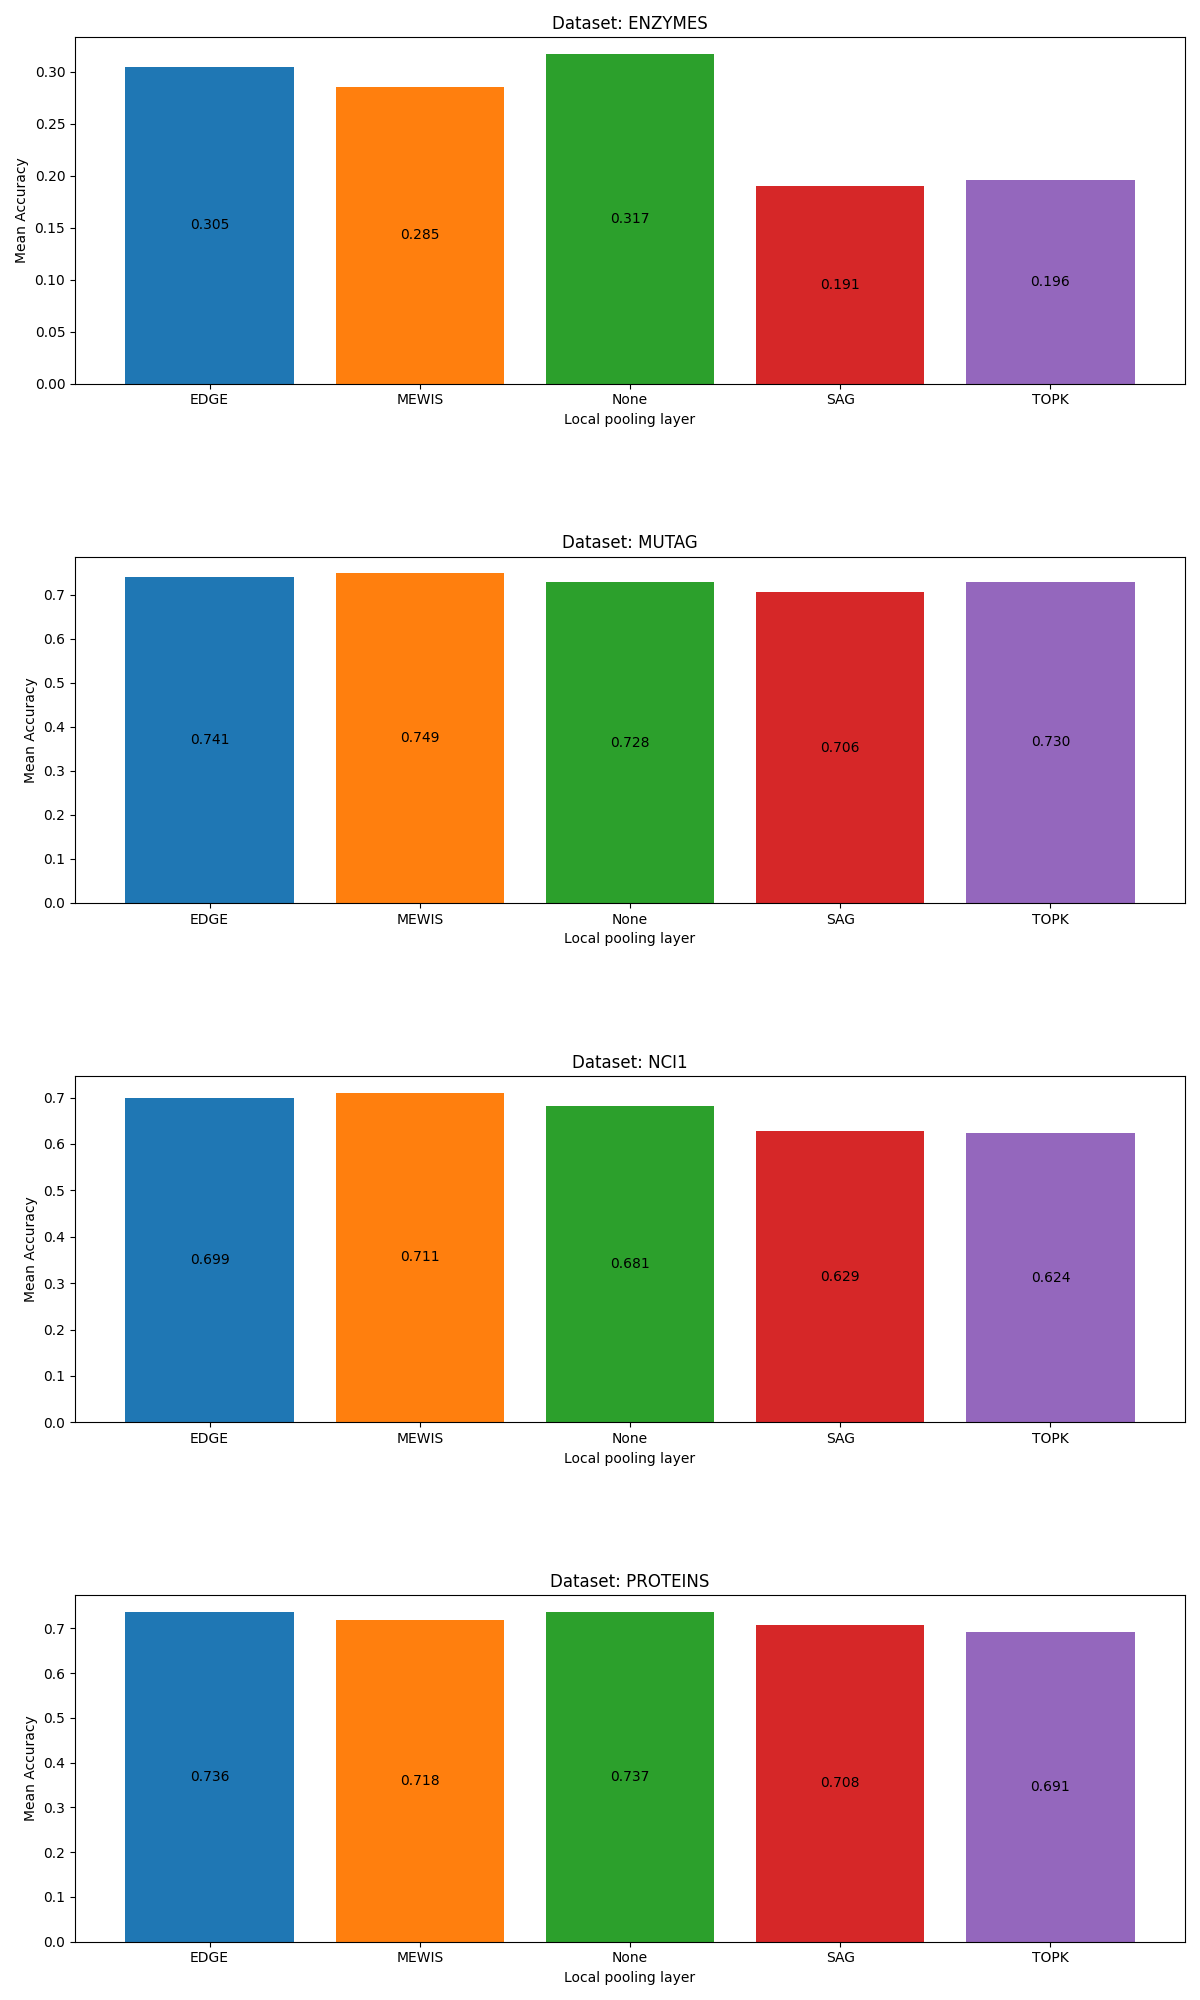

In [7]:
vplot.plot_bar_dataset(groupby="local_pooling_layer",
                       stack=None,
                       bar_width=0.12,
                       x_figsize=12,
                       padding_subplots=.005);

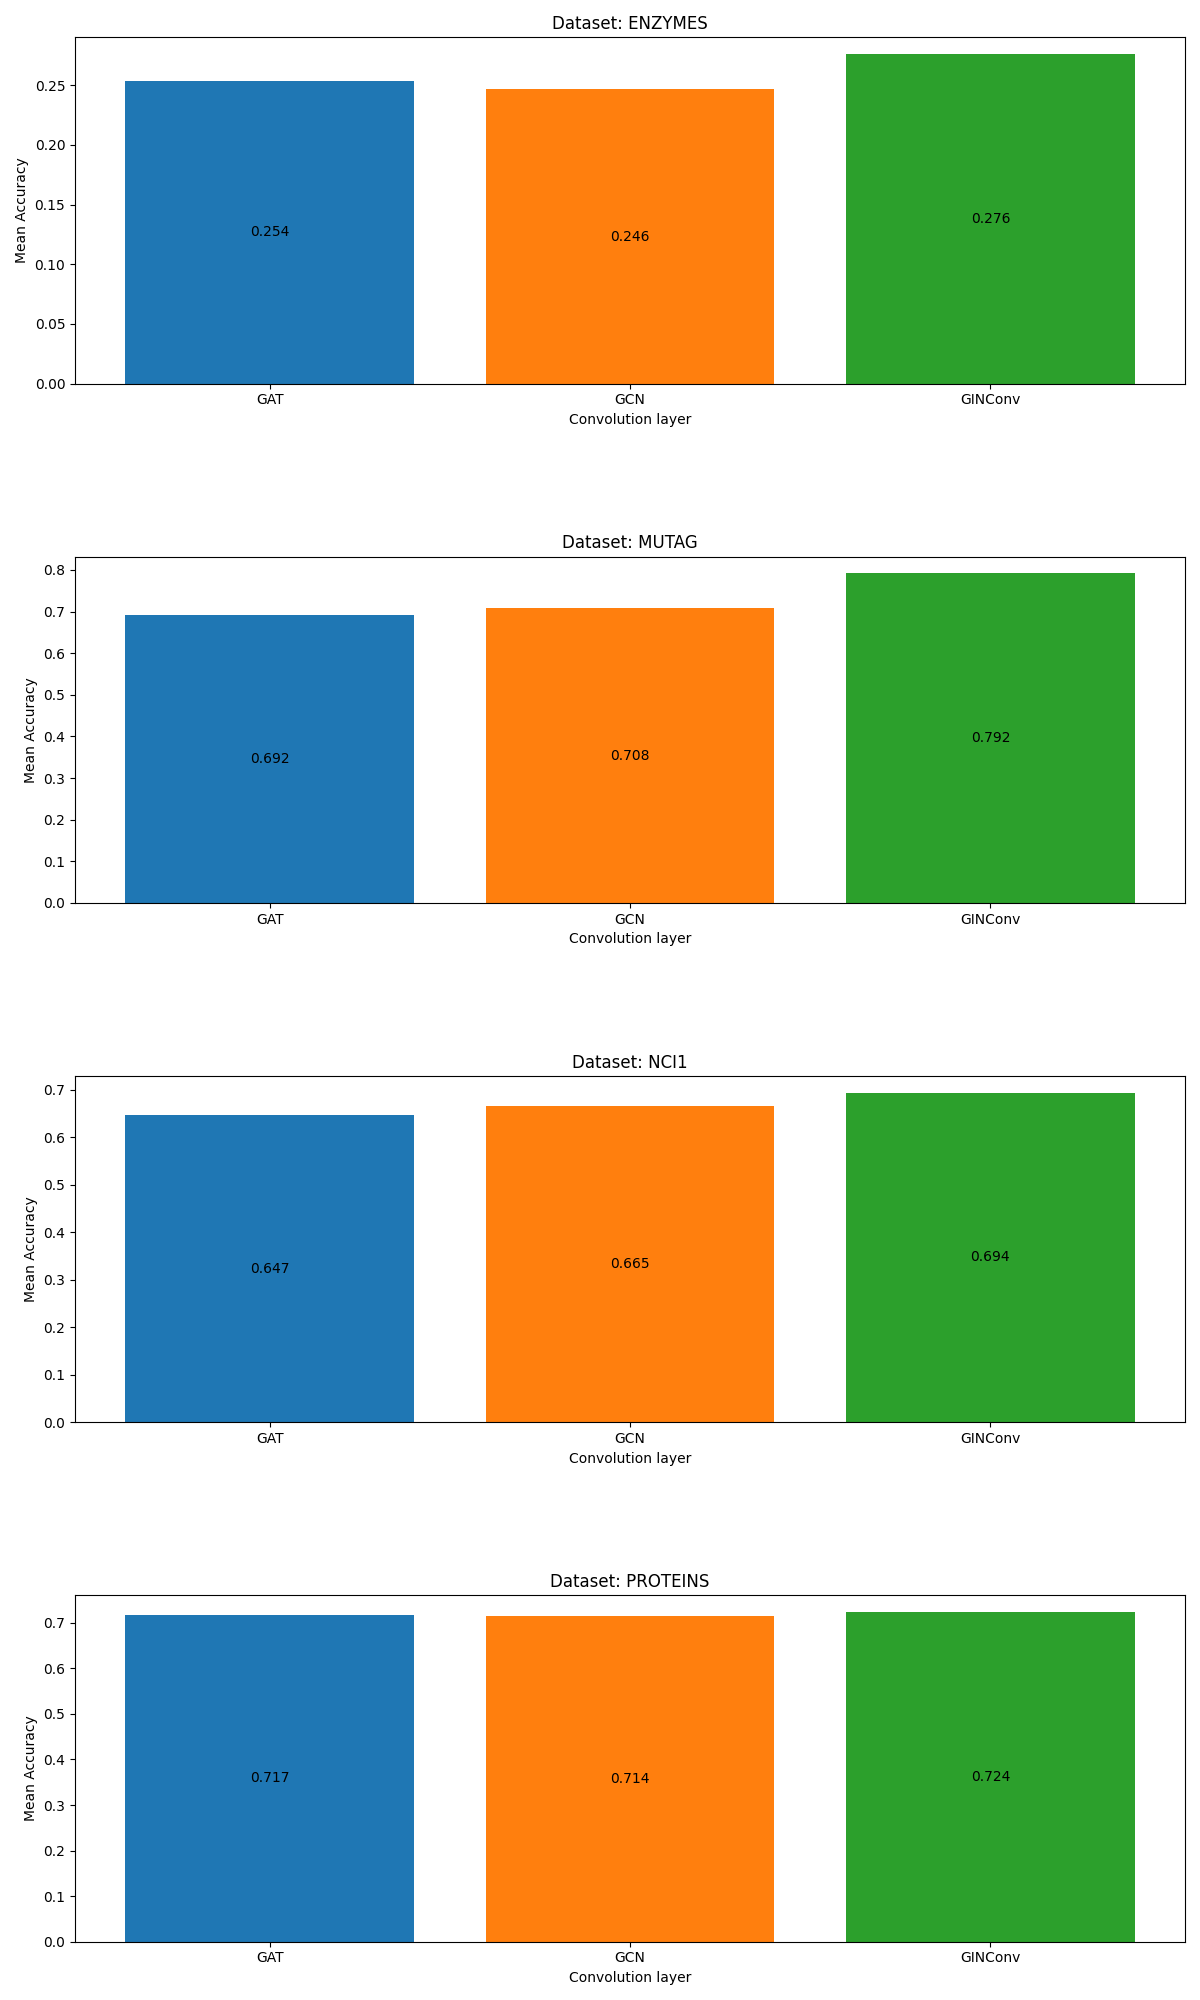

In [6]:
vplot.plot_bar_dataset(groupby="convolution_layer",
                       stack=None,
                       bar_width=0.4,
                       x_figsize=12,
                       padding_subplots=.005);

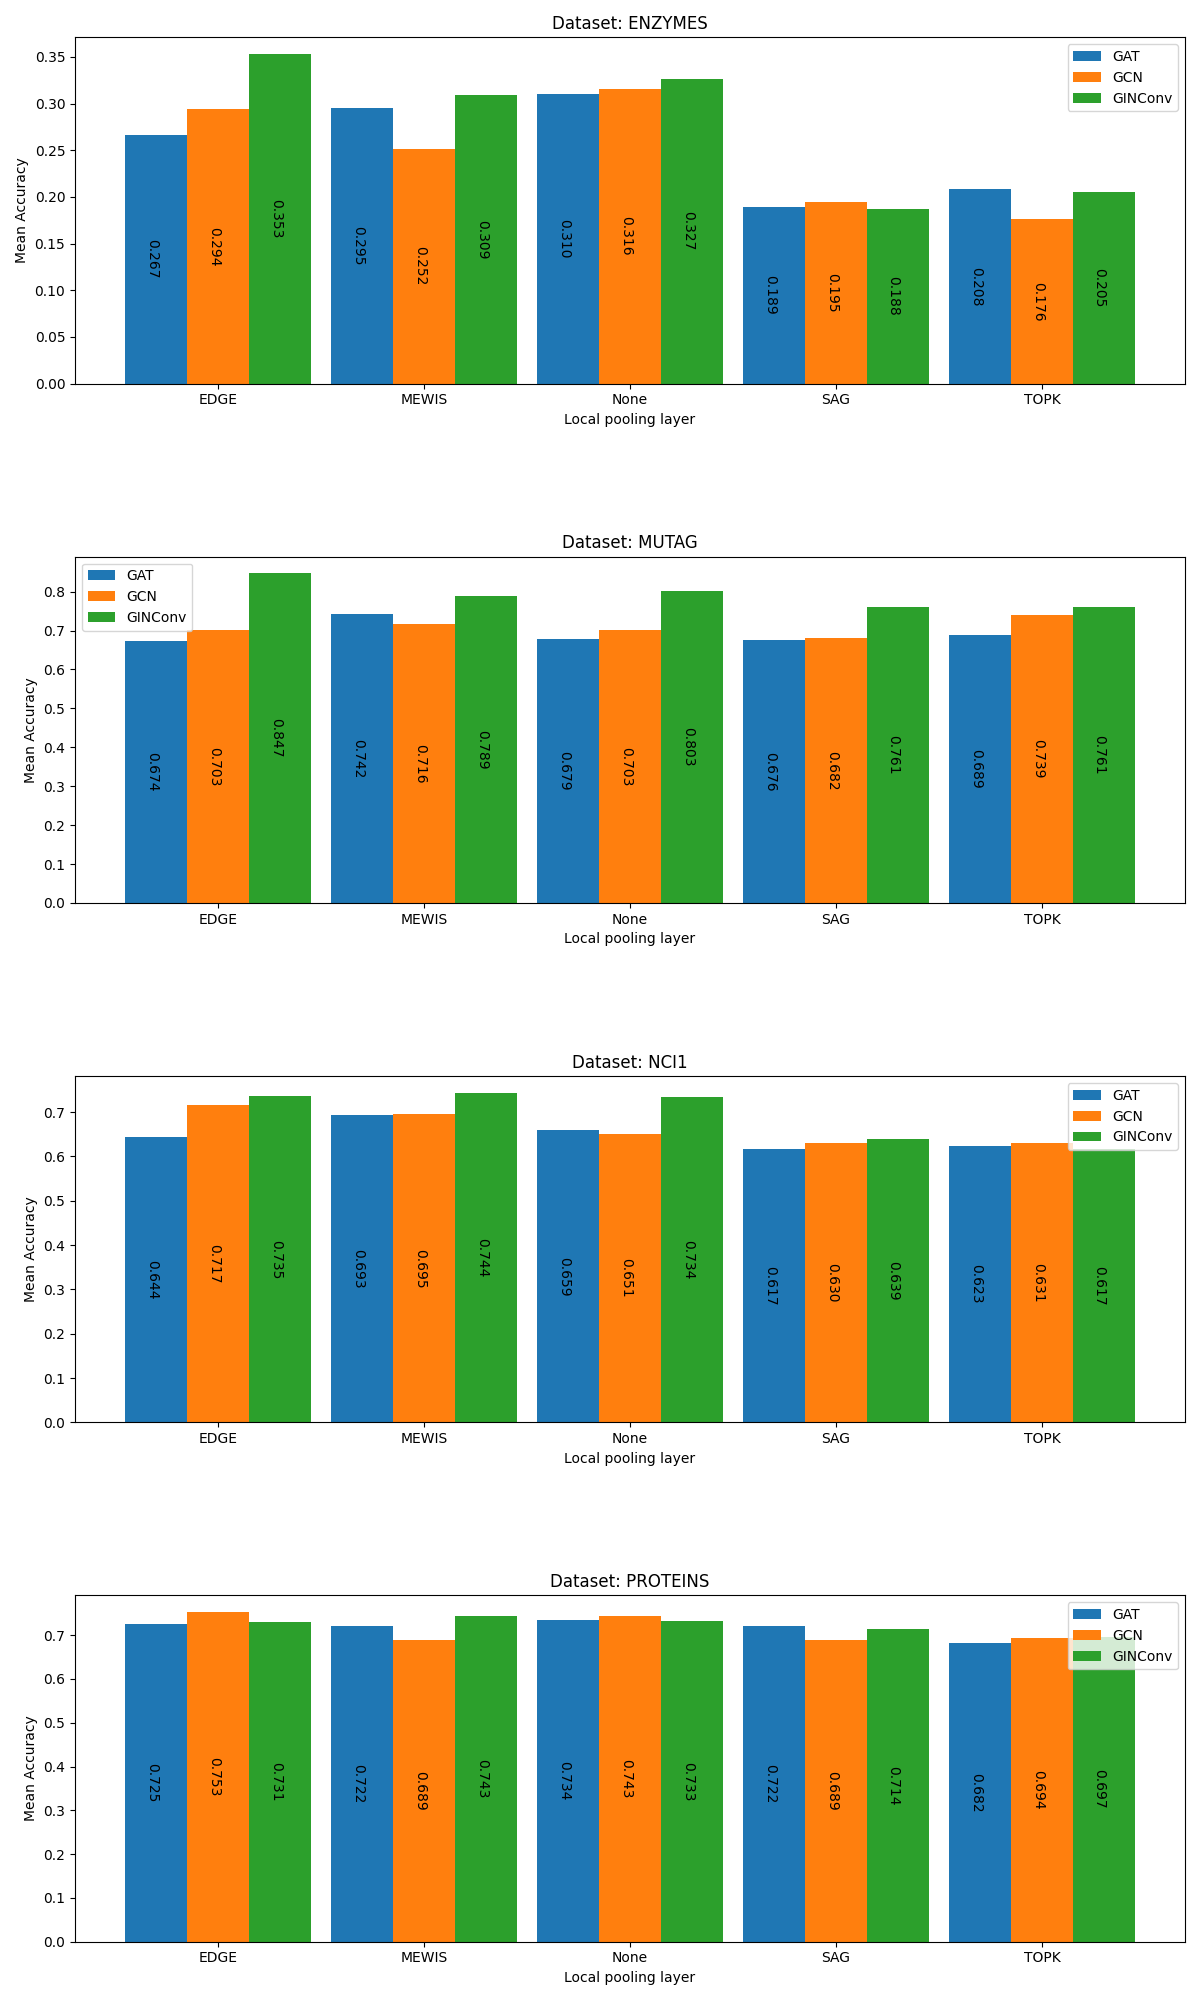

In [8]:
vplot.plot_bar_dataset(groupby="local_pooling_layer",
                       stack="convolution_layer",
                       bar_width=0.3,
                       offset = .02,
                       x_figsize=12,
                       padding_subplots=.005);

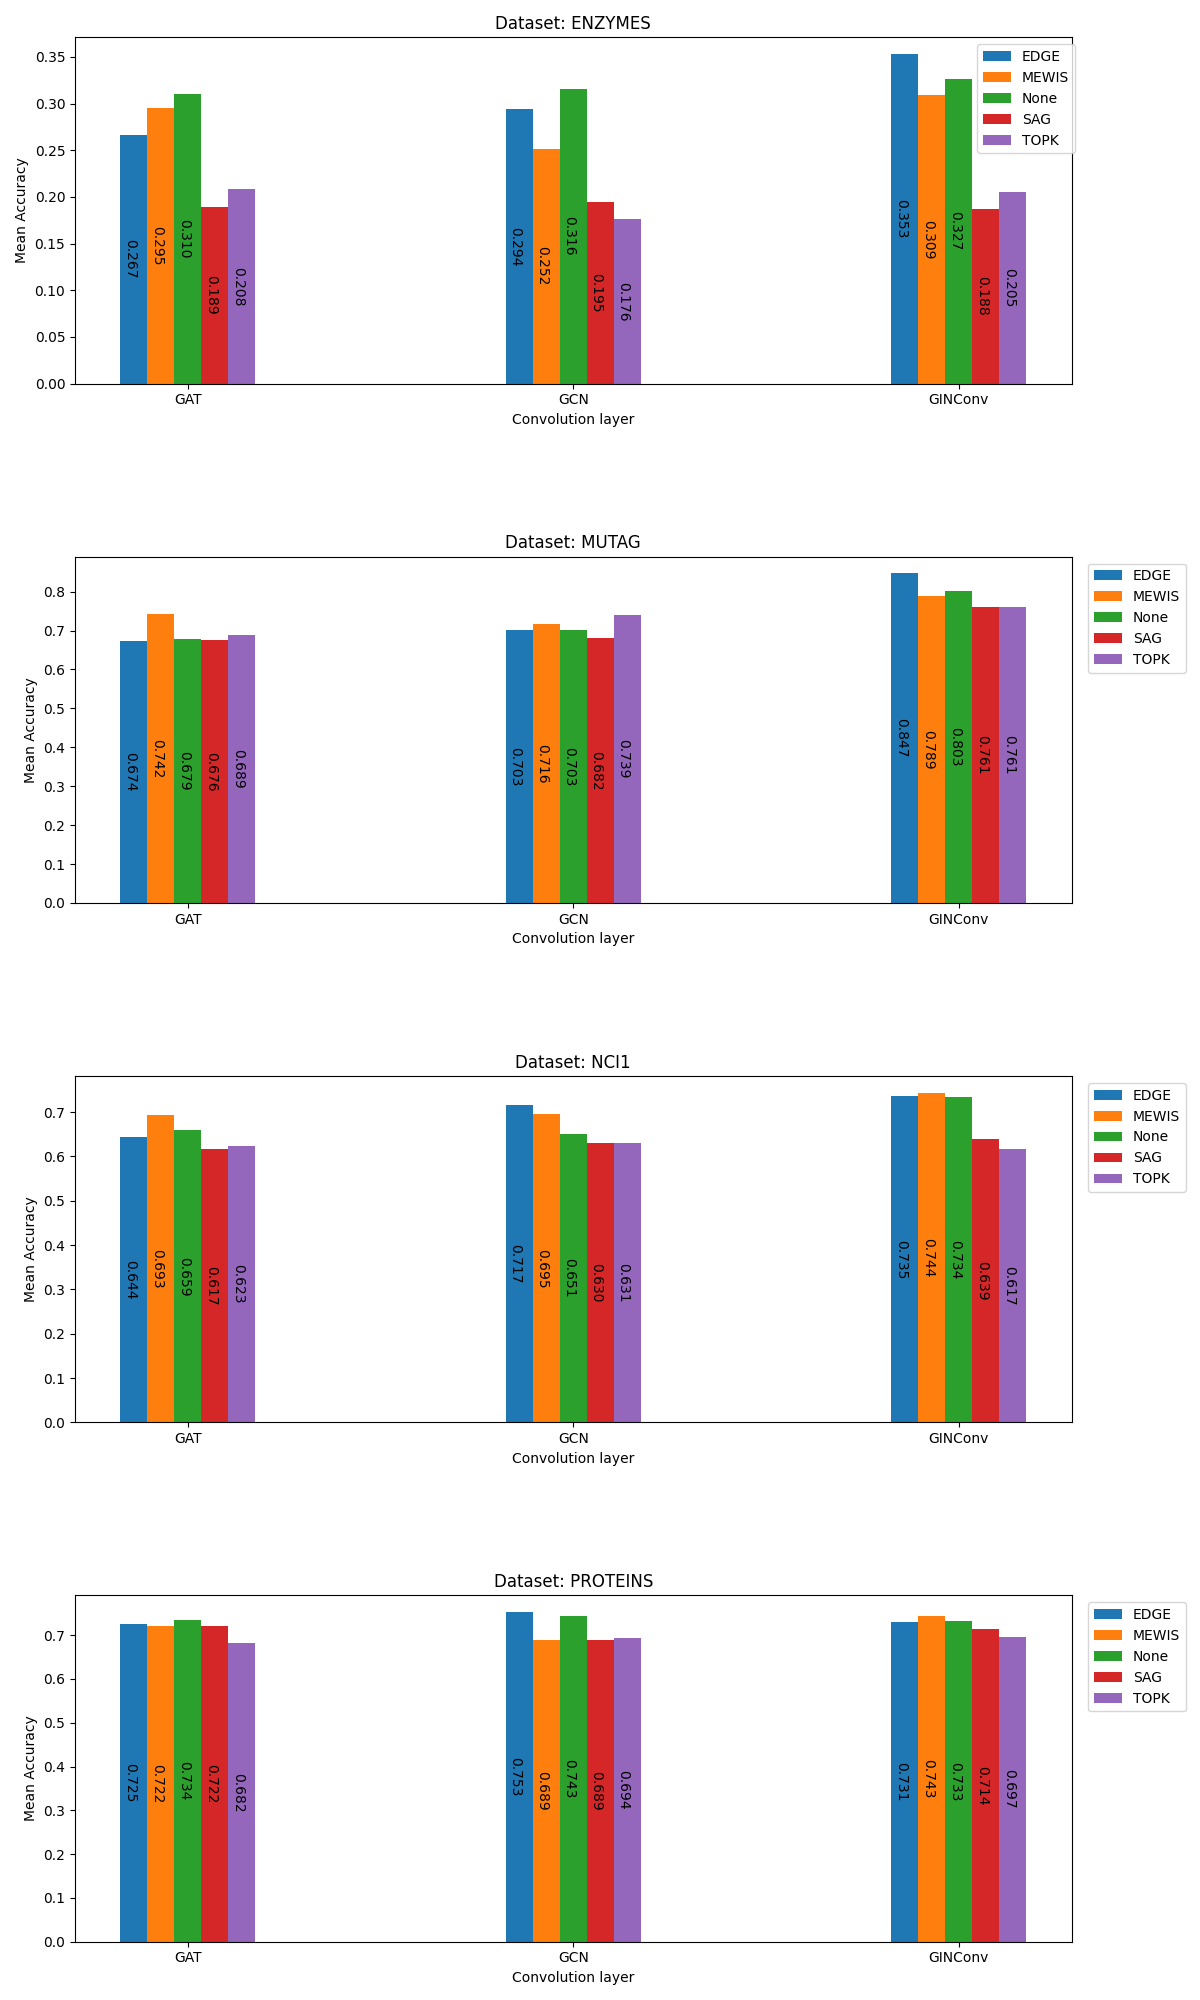

In [9]:
vplot.plot_bar_dataset(groupby="convolution_layer",
                       stack="local_pooling_layer",
                       bar_width=0.07,
                       offset=0.01,
                       x_figsize=12,
                       kwargs2={'bbox_to_anchor' : (1.01,1)},
                       padding_subplots=.005);

# II Losses

In [18]:
plot = save_plot.Plot(list_dict)

In [19]:
plot.plot_all(train=True)

In [20]:
plot.plot_all(train=False)

# III Table 

In [4]:
table = to_table.ToTable(list_dict, per_dataset=True)

In [14]:
table.save_all()

In [5]:
df, \
df_best_architecture, \
df_worst_architecture, \
average_ranking_df_archi, \
df_by_architecture, \
df_best_pooling, \
df_worst_pooling, \
average_ranking_df_pooling, \
df_by_pooling = table.get_all()

In [6]:
average_ranking_df_pooling

Dataset,ENZYMES,MUTAG,NCI1,PROTEINS
Local,,,,
EDGE,1,1,2,1
MEWIS,5,3,1,2
None,2,2,3,2
SAG,12,4,10,8
TOPK,10,4,11,11


In [7]:
average_ranking_df_archi

Dataset,ENZYMES,MUTAG,NCI1,PROTEINS
Conv,,,,
GAT,4,6,6,4
GCN,3,7,4,1
GINConv,1,1,1,2


In [8]:
df_best_architecture

Dataset,ENZYMES,MUTAG,NCI1,PROTEINS
Local,,,,
EDGE,GINConv,GINConv,GINConv,GCN
MEWIS,GINConv,GINConv,GINConv,GINConv
None,GINConv,GINConv,GINConv,GCN
SAG,GCN,GINConv,GINConv,GAT
TOPK,GAT,GINConv,GCN,GINConv


In [9]:
df_worst_architecture

Dataset,ENZYMES,MUTAG,NCI1,PROTEINS
Local,,,,
EDGE,GAT,GAT,GAT,GAT
MEWIS,GCN,GCN,GAT,GCN
None,GAT,GAT,GCN,GINConv
SAG,GINConv,GAT,GAT,GCN
TOPK,GCN,GAT,GINConv,GAT


In [10]:
df_best_pooling

Dataset,ENZYMES,MUTAG,NCI1,PROTEINS
Conv,,,,
GAT,None,MEWIS,MEWIS,None
GCN,None,TOPK,EDGE,EDGE
GINConv,EDGE,EDGE,MEWIS,MEWIS


In [11]:
df_worst_pooling

Dataset,ENZYMES,MUTAG,NCI1,PROTEINS
Conv,,,,
GAT,SAG,EDGE,SAG,TOPK
GCN,TOPK,SAG,SAG,MEWIS
GINConv,SAG,SAG,TOPK,TOPK


In [12]:
df_by_architecture

ENZYMES                   MUTAG  \
Conv    Local                                                   
GAT     MEWIS       $0.295 \pm 0.040$       $0.742 \pm 0.086$   
        None        $0.310 \pm 0.053$       $0.679 \pm 0.087$   
GCN     EDGE        $0.294 \pm 0.026$       $0.703 \pm 0.081$   
        None        $0.316 \pm 0.044$       $0.703 \pm 0.065$   
        TOPK        $0.176 \pm 0.035$       $0.739 \pm 0.075$   
GINConv EDGE   $\bm{0.353 \pm 0.039}$  $\bm{0.847 \pm 0.063}$   
        MEWIS       $0.309 \pm 0.055$       $0.789 \pm 0.077$   

                                 NCI1                PROTEINS Training Time  
Conv    Local                                                                
GAT     MEWIS       $0.693 \pm 0.008$       $0.722 \pm 0.022$          5387  
        None        $0.659 \pm 0.023$       $0.734 \pm 0.027$           138  
GCN     EDGE        $0.717 \pm 0.015$  $\bm{0.753 \pm 0.024}$          2234  
        None        $0.651 \pm 0.015$       $0.743 \pm 0.029$            55  
        TOPK        $0.631 \pm 0.034$       $0.694 \pm 0.032$            79  
GINConv EDGE        $0.735 \pm 0.010$       $0.731 \pm 0.017$          1849  
        MEWIS  $\bm{0.744 \pm 0.006}$       $0.743 \pm 0.016$          8207

In [13]:
df_by_pooling.sort_index()

ENZYMES                   MUTAG  \
Local Conv                                                      
EDGE  GCN           $0.294 \pm 0.026$       $0.703 \pm 0.081$   
      GINConv  $\bm{0.353 \pm 0.039}$  $\bm{0.847 \pm 0.063}$   
MEWIS GINConv       $0.309 \pm 0.055$       $0.789 \pm 0.077$   
None  GCN           $0.316 \pm 0.044$       $0.703 \pm 0.065$   
      GINConv       $0.327 \pm 0.042$       $0.803 \pm 0.068$   
SAG   GAT           $0.189 \pm 0.025$       $0.676 \pm 0.062$   
      GCN           $0.195 \pm 0.033$       $0.682 \pm 0.073$   
      GINConv       $0.188 \pm 0.040$       $0.761 \pm 0.081$   
TOPK  GAT           $0.208 \pm 0.054$       $0.689 \pm 0.093$   
      GCN           $0.176 \pm 0.035$       $0.739 \pm 0.075$   
      GINConv       $0.205 \pm 0.056$       $0.761 \pm 0.079$   

                                 NCI1                PROTEINS Training Time  
Local Conv                                                                   
EDGE  GCN           $0.717 \pm 0.015$  $\bm{0.753 \pm 0.024}$          2234  
      GINConv       $0.735 \pm 0.010$       $0.731 \pm 0.017$          1849  
MEWIS GINConv  $\bm{0.744 \pm 0.006}$       $0.743 \pm 0.016$          8207  
None  GCN           $0.651 \pm 0.015$       $0.743 \pm 0.029$            55  
      GINConv       $0.734 \pm 0.018$       $0.733 \pm 0.028$            98  
SAG   GAT           $0.617 \pm 0.024$       $0.722 \pm 0.050$           184  
      GCN           $0.630 \pm 0.021$       $0.689 \pm 0.041$            84  
      GINConv       $0.639 \pm 0.036$       $0.714 \pm 0.039$            96  
TOPK  GAT           $0.623 \pm 0.045$       $0.682 \pm 0.033$           181  
      GCN           $0.631 \pm 0.034$       $0.694 \pm 0.032$            79  
      GINConv       $0.617 \pm 0.033$       $0.697 \pm 0.027$            86